### Data Loading & Merging

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import warnings
warnings.filterwarnings(action='ignore')
pd.set_option('display.max_columns',None)


url = 'https://docs.google.com/spreadsheets/d/1ecopK6oyyb4d_7-QLrCr8YlgFrCetHU7-VQfnYej7JY/export?format=xlsx'
airbnb = pd.ExcelFile(url)

# List all sheets
print(airbnb.sheet_names)

['amsterdam_weekdays', 'amsterdam_weekends', 'athens_weekdays', 'athens_weekends', 'berlin_weekends', 'berlin_weekdays', 'barcelona_weekdays', 'barcelona_weekends', 'budapest_weekdays', 'budapest_weekends', 'lisbon_weekdays', 'lisbon_weekends', 'london_weekdays', 'london_weekends', 'paris_weekdays', 'paris_weekends', 'rome_weekdays', 'rome_weekends', 'vienna_weekdays', 'vienna_weekends']


In [2]:
airbnbdf= pd.read_excel(airbnb, sheet_name='amsterdam_weekdays')
print(airbnbdf.head())
print(airbnbdf.shape)

   Unnamed: 0     realSum     room_type  room_shared  room_private  \
0           0  194.033698  Private room        False          True   
1           1  344.245776  Private room        False          True   
2           2  264.101422  Private room        False          True   
3           3  433.529398  Private room        False          True   
4           4  485.552926  Private room        False          True   

   person_capacity  host_is_superhost  multi  biz  cleanliness_rating  \
0                2              False      1    0                  10   
1                4              False      0    0                   8   
2                2              False      0    1                   9   
3                4              False      0    1                   9   
4                2               True      0    0                  10   

   guest_satisfaction_overall  bedrooms      dist  metro_dist  attr_index  \
0                          93         1  5.022964    2.539380  

In [3]:
# Merge all sheets into a single DataFrame with an additional column for sheet names
merged_airbnbdf= pd.concat(
    [airbnb.parse(sheet).assign(sheet_name=sheet) for sheet in airbnb.sheet_names],
    ignore_index=True
)

# Reset index cleanly (only on merged DataFrame)
merged_airbnbdf.reset_index(drop=True, inplace=True)

print(merged_airbnbdf.shape)
print(merged_airbnbdf.head())

(51707, 21)
   Unnamed: 0     realSum     room_type  room_shared  room_private  \
0           0  194.033698  Private room        False          True   
1           1  344.245776  Private room        False          True   
2           2  264.101422  Private room        False          True   
3           3  433.529398  Private room        False          True   
4           4  485.552926  Private room        False          True   

   person_capacity  host_is_superhost  multi  biz  cleanliness_rating  \
0                2              False      1    0                  10   
1                4              False      0    0                   8   
2                2              False      0    1                   9   
3                4              False      0    1                   9   
4                2               True      0    0                  10   

   guest_satisfaction_overall  bedrooms      dist  metro_dist  attr_index  \
0                          93         1  5.022964  

### Basic Data Cleansing

In [4]:
# Split the sheet_name column into city name
merged_airbnbdf['city'] = merged_airbnbdf['sheet_name'].str.split('_').str[0].str.capitalize()

# Define a mapping of city to country
city_to_country = {
    'Amsterdam': 'Netherlands',
    'Athens': 'Greece',
    'Berlin': 'Germany',
    'Barcelona': 'Spain',
    'Budapest': 'Hungary',
    'Lisbon': 'Portugal',
    'London': 'United Kingdom',
    'Paris': 'France',
    'Rome': 'Italy',
    'Vienna': 'Austria'
}

# Map city to country
merged_airbnbdf['country'] = merged_airbnbdf['city'].map(city_to_country)

# Extract day type from sheet_name
merged_airbnbdf['day_type'] = merged_airbnbdf['sheet_name'].str.split('_').str[1].str.capitalize()


# Print the updated DataFrame
print(merged_airbnbdf.head())
print(merged_airbnbdf.shape)



   Unnamed: 0     realSum     room_type  room_shared  room_private  \
0           0  194.033698  Private room        False          True   
1           1  344.245776  Private room        False          True   
2           2  264.101422  Private room        False          True   
3           3  433.529398  Private room        False          True   
4           4  485.552926  Private room        False          True   

   person_capacity  host_is_superhost  multi  biz  cleanliness_rating  \
0                2              False      1    0                  10   
1                4              False      0    0                   8   
2                2              False      0    1                   9   
3                4              False      0    1                   9   
4                2               True      0    0                  10   

   guest_satisfaction_overall  bedrooms      dist  metro_dist  attr_index  \
0                          93         1  5.022964    2.539380  

In [5]:
# Change column name 'realSum' to 'Price' and print columns
merged_airbnbdf.rename(columns={'realSum': 'Price'}, inplace=True)
print(merged_airbnbdf.columns)

Index(['Unnamed: 0', 'Price', 'room_type', 'room_shared', 'room_private',
       'person_capacity', 'host_is_superhost', 'multi', 'biz',
       'cleanliness_rating', 'guest_satisfaction_overall', 'bedrooms', 'dist',
       'metro_dist', 'attr_index', 'attr_index_norm', 'rest_index',
       'rest_index_norm', 'lng', 'lat', 'sheet_name', 'city', 'country',
       'day_type'],
      dtype='object')


In [6]:
# Drop the 'Unnamed: 0' column
merged_airbnbdf.drop('Unnamed: 0', axis=1, inplace=True)
print(merged_airbnbdf.columns)

Index(['Price', 'room_type', 'room_shared', 'room_private', 'person_capacity',
       'host_is_superhost', 'multi', 'biz', 'cleanliness_rating',
       'guest_satisfaction_overall', 'bedrooms', 'dist', 'metro_dist',
       'attr_index', 'attr_index_norm', 'rest_index', 'rest_index_norm', 'lng',
       'lat', 'sheet_name', 'city', 'country', 'day_type'],
      dtype='object')


### Advanced Cleaning

In [7]:
# Create 'room_category' based on 'room_shared' and 'room_private'

# Initialize the new column with empty strings
merged_airbnbdf['room_category'] = pd.Series(dtype='str')

# Filling in values conditionally
merged_airbnbdf.loc[merged_airbnbdf['room_private'] == True, 'room_category'] = 'Private'
merged_airbnbdf.loc[merged_airbnbdf['room_shared'] == True, 'room_category'] = 'Shared'
merged_airbnbdf['room_category'] = merged_airbnbdf['room_category'].fillna('Other')

# Drop the 3rd and 4th columns (index 2 and 3)
merged_airbnbdf.drop(merged_airbnbdf.columns[[2, 3]], axis=1, inplace=True)

# Move 'room_category' to 3rd position column
cols = list(merged_airbnbdf.columns)
cols.insert(2, cols.pop(cols.index('room_category')))
merged_airbnbdf = merged_airbnbdf[cols]

# Print the updated DataFrame
print(merged_airbnbdf.head())
print(merged_airbnbdf.shape)
print (merged_airbnbdf.columns)


        Price     room_type room_category  person_capacity  host_is_superhost  \
0  194.033698  Private room       Private                2              False   
1  344.245776  Private room       Private                4              False   
2  264.101422  Private room       Private                2              False   
3  433.529398  Private room       Private                4              False   
4  485.552926  Private room       Private                2               True   

   multi  biz  cleanliness_rating  guest_satisfaction_overall  bedrooms  \
0      1    0                  10                          93         1   
1      0    0                   8                          85         1   
2      0    1                   9                          87         1   
3      0    1                   9                          90         2   
4      0    0                  10                          98         1   

       dist  metro_dist  attr_index  attr_index_norm  rest_ind

In [8]:
# Create 'listings by host' based on 'multi' and 'biz' columns
merged_airbnbdf['listings by host'] = np.select(
    [
        (merged_airbnbdf['multi'] == 0) & (merged_airbnbdf['biz'] == 0),
        merged_airbnbdf['multi'] == 1,
        merged_airbnbdf['biz'] == 1
    ],
    [
        '1',
        '2-4',
        '4+'
    ],
    default='Unknown'
)

# Drop the 5th and 6th columns (index 5 and 6)
merged_airbnbdf.drop(merged_airbnbdf.columns[[5, 6]], axis=1, inplace=True)

# Move 'listings by host' to 5th position column
cols = list(merged_airbnbdf.columns)
cols.insert(5, cols.pop(cols.index('listings by host')))
merged_airbnbdf = merged_airbnbdf[cols]


# Check result
print(merged_airbnbdf.head())
print(merged_airbnbdf.shape)
print(merged_airbnbdf.columns)

        Price     room_type room_category  person_capacity  host_is_superhost  \
0  194.033698  Private room       Private                2              False   
1  344.245776  Private room       Private                4              False   
2  264.101422  Private room       Private                2              False   
3  433.529398  Private room       Private                4              False   
4  485.552926  Private room       Private                2               True   

  listings by host  cleanliness_rating  guest_satisfaction_overall  bedrooms  \
0              2-4                  10                          93         1   
1                1                   8                          85         1   
2               4+                   9                          87         1   
3               4+                   9                          90         2   
4                1                  10                          98         1   

       dist  metro_dist  attr_in

In [9]:
# Readjust some column positions
cols = list(merged_airbnbdf.columns)
cols.insert(0, cols.pop(cols.index('sheet_name')))
cols.insert(1, cols.pop(cols.index('country')))
cols.insert(2, cols.pop(cols.index('city')))
cols.insert(3, cols.pop(cols.index('day_type')))

merged_airbnbdf = merged_airbnbdf[cols]

# Rename a single column
merged_airbnbdf.rename(columns={'dist': 'citycenter_dist'}, inplace=True)

# Standardize all column names to lowercase and replace spaces with underscores
merged_airbnbdf.columns = merged_airbnbdf.columns.str.lower().str.replace(' ', '_')

# Check result
print(merged_airbnbdf.head())
print(merged_airbnbdf.shape)
print(merged_airbnbdf.columns)



           sheet_name      country       city  day_type       price  \
0  amsterdam_weekdays  Netherlands  Amsterdam  Weekdays  194.033698   
1  amsterdam_weekdays  Netherlands  Amsterdam  Weekdays  344.245776   
2  amsterdam_weekdays  Netherlands  Amsterdam  Weekdays  264.101422   
3  amsterdam_weekdays  Netherlands  Amsterdam  Weekdays  433.529398   
4  amsterdam_weekdays  Netherlands  Amsterdam  Weekdays  485.552926   

      room_type room_category  person_capacity  host_is_superhost  \
0  Private room       Private                2              False   
1  Private room       Private                4              False   
2  Private room       Private                2              False   
3  Private room       Private                4              False   
4  Private room       Private                2               True   

  listings_by_host  cleanliness_rating  guest_satisfaction_overall  bedrooms  \
0              2-4                  10                          93         1  

In [10]:
# Check for duplicate rows
merged_airbnbdf.duplicated().any()


False

### Basic Initial Inspection

In [11]:
# Display the first row of the cleaned DataFrame
merged_airbnbdf.head(1)

,sheet_name,country,city,day_type,price,room_type,room_category,person_capacity,host_is_superhost,listings_by_host,cleanliness_rating,guest_satisfaction_overall,bedrooms,citycenter_dist,metro_dist,attr_index,attr_index_norm,rest_index,rest_index_norm,lng,lat
0,amsterdam_weekdays,Netherlands,Amsterdam,Weekdays,194.033698,Private room,Private,2,False,2-4,10,93,1,5.022964,2.53938,78.690379,4.166708,98.253896,6.846473,4.90569,52.41772


In [12]:
# Display the last row of the cleaned DataFrame
merged_airbnbdf.tail(1)

,sheet_name,country,city,day_type,price,room_type,room_category,person_capacity,host_is_superhost,listings_by_host,cleanliness_rating,guest_satisfaction_overall,bedrooms,citycenter_dist,metro_dist,attr_index,attr_index_norm,rest_index,rest_index_norm,lng,lat
51706,vienna_weekends,Austria,Vienna,Weekends,133.230489,Private room,Private,4,True,2-4,10,93,1,1.263932,0.480903,150.450381,10.774264,225.247293,5.44414,16.39066,48.20811


In [13]:
# Display a random sample of 7 rows from the cleaned DataFrame
random_sample = merged_airbnbdf.sample(7, random_state=42)
random_sample

,sheet_name,country,city,day_type,price,room_type,room_category,person_capacity,host_is_superhost,listings_by_host,cleanliness_rating,guest_satisfaction_overall,bedrooms,citycenter_dist,metro_dist,attr_index,attr_index_norm,rest_index,rest_index_norm,lng,lat
12395,barcelona_weekends,Spain,Barcelona,Weekends,160.821095,Private room,Private,4,True,2-4,8,88,1,4.795292,0.666605,176.133866,6.800732,297.124845,6.526835,2.18120,41.42950
44703,rome_weekends,Italy,Rome,Weekends,182.124237,Entire home/apt,Other,4,False,1,10,98,0,6.675412,0.411363,186.778096,4.138152,462.481905,10.076359,12.42200,41.90500
49956,vienna_weekends,Austria,Vienna,Weekends,658.672837,Entire home/apt,Other,6,False,4+,9,86,2,1.423964,0.148752,125.339104,8.975960,203.945695,4.929289,16.38206,48.22004
6129,athens_weekends,Greece,Athens,Weekends,133.339582,Entire home/apt,Other,5,False,1,10,96,2,1.657024,0.984947,101.973856,3.842144,131.349579,1.961567,23.74306,37.96193
3227,athens_weekdays,Greece,Athens,Weekdays,173.880440,Entire home/apt,Other,4,True,2-4,10,96,1,1.371064,0.170704,100.881520,3.803653,154.423345,11.595045,23.75058,37.97838
5923,athens_weekends,Greece,Athens,Weekends,191.221616,Entire home/apt,Other,5,False,2-4,10,95,2,0.390960,0.377241,326.338626,12.295701,583.637300,8.716004,23.73100,37.97500
4506,athens_weekdays,Greece,Athens,Weekdays,150.212078,Entire home/apt,Other,4,False,1,9,94,2,3.437280,0.396319,49.821172,1.878465,73.139317,5.491745,23.73224,38.00642


In [14]:
# Checkd Datatypes  
merged_airbnbdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51707 entries, 0 to 51706
Data columns (total 21 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   sheet_name                  51707 non-null  object 
 1   country                     51707 non-null  object 
 2   city                        51707 non-null  object 
 3   day_type                    51707 non-null  object 
 4   price                       51707 non-null  float64
 5   room_type                   51707 non-null  object 
 6   room_category               51707 non-null  object 
 7   person_capacity             51707 non-null  int64  
 8   host_is_superhost           51707 non-null  bool   
 9   listings_by_host            51707 non-null  object 
 10  cleanliness_rating          51707 non-null  int64  
 11  guest_satisfaction_overall  51707 non-null  int64  
 12  bedrooms                    51707 non-null  int64  
 13  citycenter_dist             517

In [15]:
#Descriptive statistics of the DataFrame
merged_airbnbdf.describe().round(2)

,price,person_capacity,cleanliness_rating,guest_satisfaction_overall,bedrooms,citycenter_dist,metro_dist,attr_index,attr_index_norm,rest_index,rest_index_norm,lng,lat
count,51707.00,51707.00,51707.00,51707.00,51707.00,51707.00,51707.00,51707.00,51707.00,51707.00,51707.00,51707.00,51707.00
mean,279.88,3.16,9.39,92.63,1.16,3.19,0.68,294.20,13.42,626.86,22.79,7.43,45.67
std,327.95,1.30,0.95,8.95,0.63,2.39,0.86,224.75,9.81,497.92,17.80,9.80,5.25
min,34.78,2.00,2.00,20.00,0.00,0.02,0.00,15.15,0.93,19.58,0.59,-9.23,37.95
25%,148.75,2.00,9.00,90.00,1.00,1.45,0.25,136.80,6.38,250.85,8.75,-0.07,41.40
50%,211.34,3.00,10.00,95.00,1.00,2.61,0.41,234.33,11.47,522.05,17.54,4.87,47.51
75%,319.69,4.00,10.00,99.00,1.00,4.26,0.74,385.76,17.42,832.63,32.96,13.52,51.47
max,18545.45,6.00,10.00,100.00,10.00,25.28,14.27,4513.56,100.00,6696.16,100.00,23.79,52.64


In [16]:
#Category Columns
category_columns = merged_airbnbdf.select_dtypes(include=['object']).columns
category_columns

Index(['sheet_name', 'country', 'city', 'day_type', 'room_type',
       'room_category', 'listings_by_host'],
      dtype='object')

In [17]:

cat_summary = {}

for col in category_columns:
    vc = merged_airbnbdf[col].value_counts(dropna=False)
    cat_summary[col] = [
        merged_airbnbdf[col].count(),
        merged_airbnbdf[col].nunique(dropna=False),
        vc.idxmax(),
        vc.max(),
        vc.idxmin(),
        vc.min()
    ]

cat_summary_table = pd.DataFrame(
    cat_summary,
    index=[
        'Count',
        'Number of unique values',
        'Most frequent value',
        'Most frequent value (frequency)',
        'Least frequent value',
        'Least frequent value (frequency)'
    ]
)

cat_summary_table

,sheet_name,country,city,day_type,room_type,room_category,listings_by_host
Count,51707,51707,51707,51707,51707,51707,51707
Number of unique values,20,10,10,2,3,3,3
Most frequent value,london_weekends,United Kingdom,London,Weekends,Entire home/apt,Other,1
Most frequent value (frequency),5379,9993,9993,26207,32648,32648,18534
Least frequent value,amsterdam_weekends,Netherlands,Amsterdam,Weekdays,Shared room,Shared,2-4
Least frequent value (frequency),977,2080,2080,25500,366,366,15065


### Exploratory Questions

In [18]:
#Q1. How many listings are in each city in total and also per type of day?

#listing per city
listing_per_city=merged_airbnbdf.groupby(['city']).size()
listing_per_city.to_frame(name='Total listings per city')


,Total listings per city
city,
Amsterdam,2080
Athens,5280
Barcelona,2833
Berlin,2484
Budapest,4022
Lisbon,5763
London,9993
Paris,6688
Rome,9027


In [19]:
#Q1. How many listings are in each city per type of day?

#listing per city and day type
listing_per_city_daytype=merged_airbnbdf.groupby(['city','day_type']).size()
listing_per_city_daytype.to_frame(name='Total listings per city and day type')



Total listings per city and day type
city      day_type                                      
Amsterdam Weekdays                                  1103
          Weekends                                   977
Athens    Weekdays                                  2653
          Weekends                                  2627
Barcelona Weekdays                                  1555
          Weekends                                  1278
Berlin    Weekdays                                  1284
          Weekends                                  1200
Budapest  Weekdays                                  2074
          Weekends                                  1948
Lisbon    Weekdays                                  2857
          Weekends                                  2906
London    Weekdays                                  4614
          Weekends                                  5379
Paris     Weekdays                                  3130
          Weekends                                  3558
Rome      Weekdays                                  4492
          Weekends                                  4535
Vienna    Weekdays                                  1738
          Weekends                                  1799

In [20]:
#Q2. Which city has the biggest proportion of superhosts?

superhost = (
    merged_airbnbdf[merged_airbnbdf["host_is_superhost"]]
    .groupby('city')
    .size()
    .to_frame(name='Superhosts_per_city')
    .sort_values(by='Superhosts_per_city', ascending=False)
)

print("The city which has the biggest proportion of superhosts is:", superhost['Superhosts_per_city'].idxmax())
superhost

The city which has the biggest proportion of superhosts is: Rome


,Superhosts_per_city
city,
Rome,2949
Athens,2263
London,1573
Budapest,1524
Lisbon,1233
Vienna,1005
Paris,941
Berlin,639
Amsterdam,591


In [21]:
#Q3. Which cities have listings with more than four rooms?

# Print cities with bedrooms >= 4
print(
    "Cities with listings having 4 or more bedrooms:",
    ', '.join(merged_airbnbdf.loc[merged_airbnbdf["bedrooms"] >= 4, "city"].unique())
)
# Print count of listings with 4 or more bedrooms per city
merged_airbnbdf.loc[merged_airbnbdf['bedrooms'] >= 4, ['city', 'bedrooms']].groupby('city').size()


Cities with listings having 4 or more bedrooms: Amsterdam, Athens, Berlin, Barcelona, Lisbon, London, Paris, Rome, Vienna


city
Amsterdam    20
Athens        2
Barcelona     4
Berlin        5
Lisbon       25
London       36
Paris         7
Rome         16
Vienna        7
dtype: int64

In [22]:
#Q4. Which city has the most entire home/apt type listings?

# Filter for 'Entire home/apt' listings and count per city
entire_home_counts = (
    merged_airbnbdf[merged_airbnbdf["room_type"] == "Entire home/apt"]
    .groupby("city")
    .size()
    .to_frame(name="Entire_home_count")
    .sort_values(by="Entire_home_count", ascending=False)
)

print(entire_home_counts)

# Print the city with the highest number
print(f"\nThe city with the most entire home/apt listings is: {entire_home_counts.index[0]}")


           Entire_home_count
city                        
Rome                    5561
Paris                   5067
Athens                  4872
London                  4384
Lisbon                  3878
Budapest                3589
Vienna                  2747
Amsterdam               1126
Berlin                   882
Barcelona                542

The city with the most entire home/apt listings is: Rome


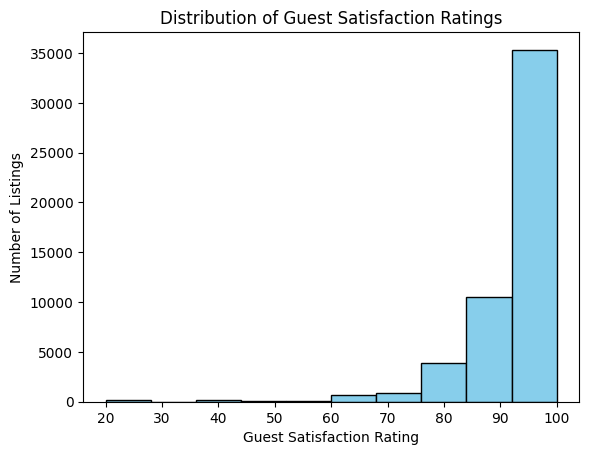

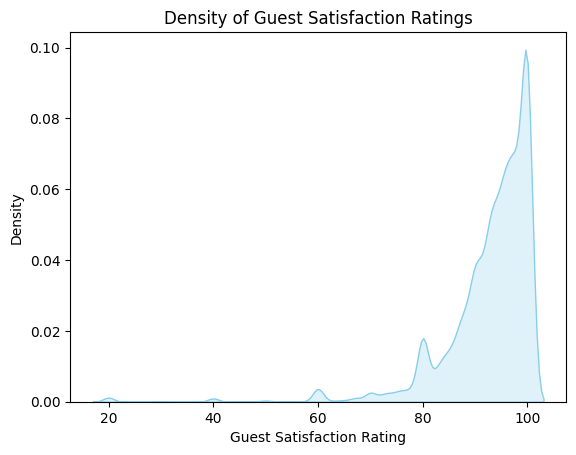


Analysis: Most Airbnb listings have high guest satisfaction ratings, with the bulk of listings 
clustered between 90 and 100. The distribution is skewed toward the top, with very few low-rated listings. 
This shows that guests are generally very satisfied across listings.



In [23]:
#Q5. Are ratings typically high across listings, or is there a wide variation? 
#a. Plot the distribution of guest_satisfaction_overall ratings.

# Visualizating for guest_satisfaction_overall through Histogram. 
plt.hist(merged_airbnbdf['guest_satisfaction_overall'], bins=10, color='skyblue', edgecolor='black')
plt.title('Distribution of Guest Satisfaction Ratings')
plt.xlabel('Guest Satisfaction Rating')
plt.ylabel('Number of Listings')
plt.show()

# Visualizating for guest_satisfaction_overall through Density Plot.
sns.kdeplot(merged_airbnbdf['guest_satisfaction_overall'], shade=True, color='skyblue')
plt.title('Density of Guest Satisfaction Ratings')
plt.xlabel('Guest Satisfaction Rating')
plt.ylabel('Density')
plt.show()

# Printing Quick Statistics for cleanliness_rating
merged_airbnbdf['guest_satisfaction_overall'].describe()

# Print Analysis
print("""
Analysis: Most Airbnb listings have high guest satisfaction ratings, with the bulk of listings 
clustered between 90 and 100. The distribution is skewed toward the top, with very few low-rated listings. 
This shows that guests are generally very satisfied across listings.
""")


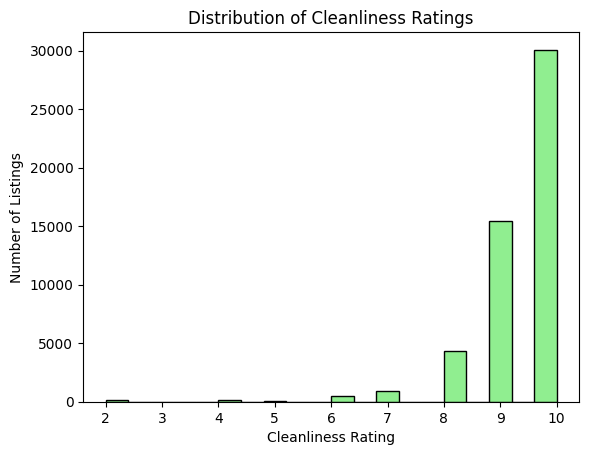

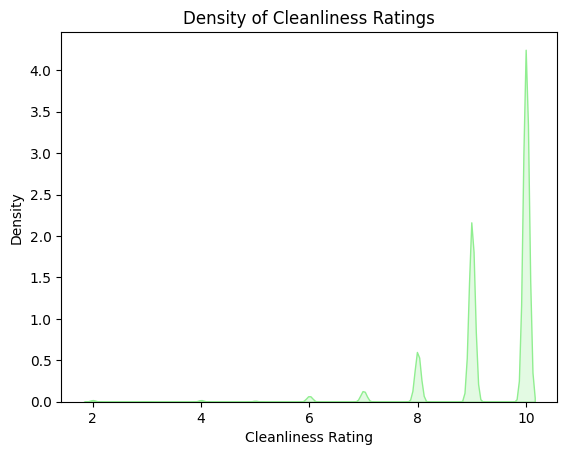


    Analysis: The cleanliness ratings are extremely high and consistent across listings. 
    Most listings score 9 or 10, showing that hosts maintain a very high standard of cleanliness. 
    Also, there is no major variation, indicating that cleanliness is uniformly excellent across 
    the dataset.  
      


In [24]:
#b. Examine the distribution of cleanliness_rating.

# Visualizating for cleanliness_rating through Histogram.
plt.hist(merged_airbnbdf['cleanliness_rating'], bins=20, color='lightgreen', edgecolor='black')
plt.title('Distribution of Cleanliness Ratings')
plt.xlabel('Cleanliness Rating')
plt.ylabel('Number of Listings')
plt.show()

# Visualizating for cleanliness_rating through Density Plot.
sns.kdeplot(merged_airbnbdf['cleanliness_rating'], shade=True, color='lightgreen', bw_adjust=0.5)
plt.title('Density of Cleanliness Ratings')
plt.xlabel('Cleanliness Rating')
plt.ylabel('Density')
plt.show()

# Printing Quick Statistics for cleanliness_rating
merged_airbnbdf['cleanliness_rating'].describe()

# Print Analysis:
print("""
    Analysis: The cleanliness ratings are extremely high and consistent across listings. 
    Most listings score 9 or 10, showing that hosts maintain a very high standard of cleanliness. 
    Also, there is no major variation, indicating that cleanliness is uniformly excellent across 
    the dataset.  
      """
      )




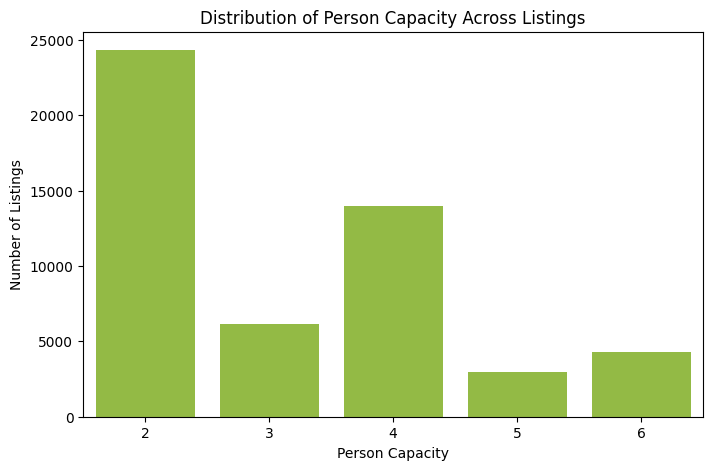


The majority of AirBnb listings in the dataset are designed for 2 to 4 guests, with 2-person listings
being the most common. Listings for larger groups of 5 or 6 people are relatively rare. This suggests 
that the market is skewed toward small to medium-sized groups, likely reflecting typical traveler demand.



In [25]:
#Q6. How does person_capacity vary across listings? What is the most common capacity of listings?

# Visualizating for person_capacity through Count Plot.
plt.figure(figsize=(8,5))
sns.countplot(x='person_capacity', data=merged_airbnbdf, color='yellowgreen')
plt.title('Distribution of Person Capacity Across Listings')
plt.xlabel('Person Capacity')
plt.ylabel('Number of Listings')
plt.show()


# Most common capacity
most_common_capacity = merged_airbnbdf['person_capacity'].mode()[0]
print("""
The majority of AirBnb listings in the dataset are designed for 2 to 4 guests, with 2-person listings
being the most common. Listings for larger groups of 5 or 6 people are relatively rare. This suggests 
that the market is skewed toward small to medium-sized groups, likely reflecting typical traveler demand.
""")



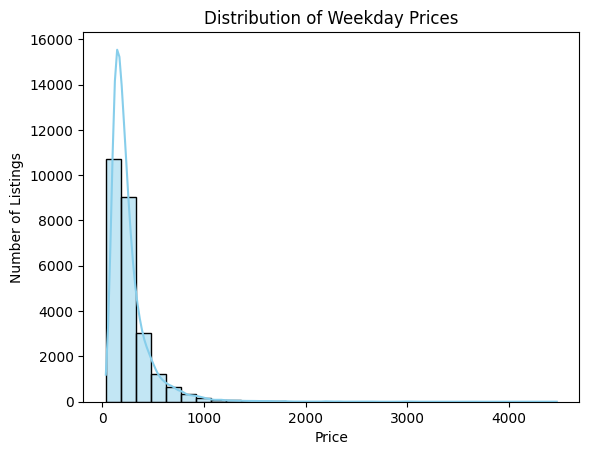

Weekday Prices Skewness: 24.094061489931633
Weekday Prices Kurtosis: 939.0255169318408
Weekday Prices Modality: Unimodal (The histrogram shows a single peak)
Weekday Prices Shapiro-Wilk Test p-value: 1.0687557663662403e-82
Weekday prices: Data is not normal


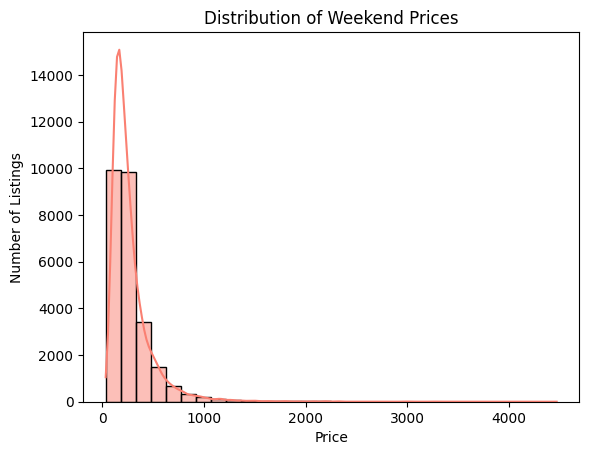

Weekend Prices Skewness: 16.602198409689024
Weekend Prices Kurtosis: 565.6951641099274
Weekend Prices Modality: Unimodal (The histrogram shows a single peak)
Weekend Prices Shapiro-Wilk Test p-value: 1.0834356845578613e-77
Weekend prices: Data is not normal

Analysis: The distribution of Airbnb prices for both weekdays and weekends is highly right-skewed, 
with skewness values of 24.1 for weekdays and 16.6 for weekends. Both distributions have 
extremely high kurtosis (939 for weekdays, 566 for weekends), indicating heavy tails and 
the presence of extreme outliers. The histograms show a unimodal distribution, with a single 
peak at lower price ranges. The Shapiro-Wilk test on a sample of 5,000 listings confirms that 
the price distributions are not normal (p-values << 0.05). Overall, most listings are clustered
at lower prices, but a few extremely high-priced listings create a long right tail.
      


In [26]:
# Q7. Plot the distribution of price (former realSum) for both weekday and weekend offers 
# a. check normality, skewness, modality

from scipy.stats import skew, kurtosis, shapiro

# Separate prices for weekdays and weekends
weekday_prices = merged_airbnbdf[merged_airbnbdf['day_type'] == 'Weekdays']['price']
weekend_prices = merged_airbnbdf[merged_airbnbdf['day_type'] == 'Weekends']['price']

# Take a random sample (e.g., 5000) from a large dataset
weekday_sample = merged_airbnbdf[merged_airbnbdf['day_type'] == 'Weekdays']['price'].sample(5000, random_state=1)
weekend_sample = merged_airbnbdf[merged_airbnbdf['day_type'] == 'Weekends']['price'].sample(5000, random_state=1)

# Plot for weekdays
sns.histplot(weekday_prices[weekday_prices < 5000], bins=30, kde=True, color='skyblue')
plt.title("Distribution of Weekday Prices")
plt.xlabel("Price")
plt.ylabel("Number of Listings")
plt.show()

print("Weekday Prices Skewness:", skew(weekday_prices))
print("Weekday Prices Kurtosis:", kurtosis(weekday_prices))
print("Weekday Prices Modality: Unimodal (The histrogram shows a single peak)")

# Shapiro-Wilk test for Weekday prices
stat_w, p_w = shapiro(weekday_sample)
print("Weekday Prices Shapiro-Wilk Test p-value:", p_w)
if p_w > 0.05:
    print("Weekday prices: Data looks normal")
else:
    print("Weekday prices: Data is not normal")


#  Plot for weekends
sns.histplot(weekend_prices[weekend_prices < 5000], bins=30, kde=True, color='salmon')
plt.title("Distribution of Weekend Prices")
plt.xlabel("Price")
plt.ylabel("Number of Listings")
plt.show()

print("Weekend Prices Skewness:", skew(weekend_prices))
print("Weekend Prices Kurtosis:", kurtosis(weekend_prices))
print("Weekend Prices Modality: Unimodal (The histrogram shows a single peak)")

stat_we, p_we = shapiro(weekend_sample)
print("Weekend Prices Shapiro-Wilk Test p-value:", p_we)
if p_we > 0.05:
    print("Weekend prices: Data looks normal")
else:
    print("Weekend prices: Data is not normal")

# Print Analysis
print("""
Analysis: The distribution of Airbnb prices for both weekdays and weekends is highly right-skewed, 
with skewness values of 24.1 for weekdays and 16.6 for weekends. Both distributions have 
extremely high kurtosis (939 for weekdays, 566 for weekends), indicating heavy tails and 
the presence of extreme outliers. The histograms show a unimodal distribution, with a single 
peak at lower price ranges. The Shapiro-Wilk test on a sample of 5,000 listings confirms that 
the price distributions are not normal (p-values << 0.05). Overall, most listings are clustered
at lower prices, but a few extremely high-priced listings create a long right tail.
      """)

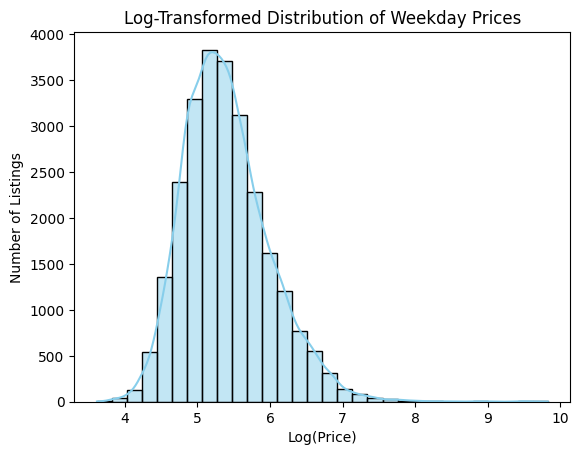

Weekday Prices Skewness: 0.7605021313682082
Weekday Prices Kurtosis: 1.5154524233984894
Weekday Prices Modality: Unimodal (The histrogram shows a single peak)
Weekday Prices (log) Shapiro-Wilk Test p-value: 2.738237763375974e-30
Weekday prices (log): Data is not normal


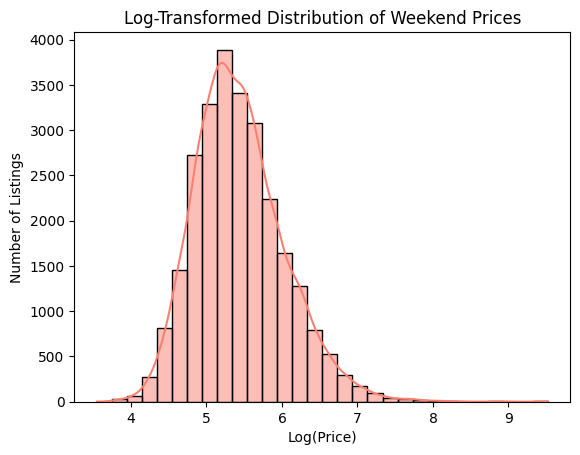

Weekend Prices Skewness: 0.6604893669243134
Weekend Prices Kurtosis: 1.099618932540106
Weekend Prices Modality: Unimodal (The histrogram shows a single peak)
Weekend Prices (log) Shapiro-Wilk Test p-value: 1.0718811080833072e-27
Weekend prices (log): Data is not normal

Analysis: The log-transformed distribution of Airbnb prices for both weekdays and weekends 
is much closer to a symmetric shape, with skewness reduced to around 0.76 for weekdays and 0.66 for 
weekends, and lower kurtosis values (1.52 for weekdays, 1.10 for weekends). Both distributions 
remain unimodal, with a single peak visible in the histograms. While the Shapiro-Wilk test still 
indicates non-normality (p-values << 0.05), the log transformation effectively reduces the influence 
of extreme high-priced listings.
        


In [27]:
#b. If skewed, consider using transformations (e.g. log); can you normalize it?

# Log transformation
weekday_prices_log = np.log(weekday_prices)
weekend_prices_log = np.log(weekend_prices)

# Take a random sample from log-transformed prices
weekday_sample_log = weekday_prices_log.sample(5000, random_state=1)
weekend_sample_log = weekend_prices_log.sample(5000, random_state=1)


# Plot transformed distributions
sns.histplot(weekday_prices_log, bins=30, kde=True, color='skyblue')
plt.title("Log-Transformed Distribution of Weekday Prices")
plt.xlabel("Log(Price)")
plt.ylabel("Number of Listings")
plt.show()

print("Weekday Prices Skewness:", skew(weekday_prices_log))
print("Weekday Prices Kurtosis:", kurtosis(weekday_prices_log))
print("Weekday Prices Modality: Unimodal (The histrogram shows a single peak)")

# Shapiro-Wilk test
stat, p = shapiro(weekday_sample_log)
print("Weekday Prices (log) Shapiro-Wilk Test p-value:", p)
if p > 0.05:
    print("Weekday prices (log): Data looks approximately normal")
else:
    print("Weekday prices (log): Data is not normal")


sns.histplot(weekend_prices_log, bins=30, kde=True, color='salmon')
plt.title("Log-Transformed Distribution of Weekend Prices")
plt.xlabel("Log(Price)")
plt.ylabel("Number of Listings")
plt.show()

print("Weekend Prices Skewness:", skew(weekend_prices_log))
print("Weekend Prices Kurtosis:", kurtosis(weekend_prices_log))
print("Weekend Prices Modality: Unimodal (The histrogram shows a single peak)")
# Shapiro-Wilk test
stat, p = shapiro(weekend_sample_log)
print("Weekend Prices (log) Shapiro-Wilk Test p-value:", p)
if p > 0.05:
    print("Weekend prices (log): Data looks approximately normal")
else:
    print("Weekend prices (log): Data is not normal")


# Print Analysis
print("""
Analysis: The log-transformed distribution of Airbnb prices for both weekdays and weekends 
is much closer to a symmetric shape, with skewness reduced to around 0.76 for weekdays and 0.66 for 
weekends, and lower kurtosis values (1.52 for weekdays, 1.10 for weekends). Both distributions 
remain unimodal, with a single peak visible in the histograms. While the Shapiro-Wilk test still 
indicates non-normality (p-values << 0.05), the log transformation effectively reduces the influence 
of extreme high-priced listings.
        """)



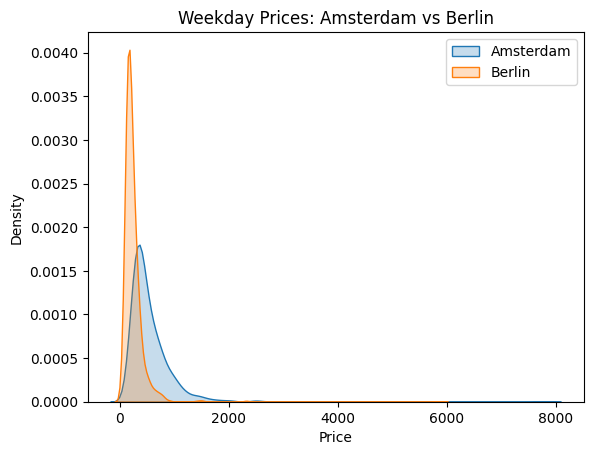

Amsterdam vs Berlin: t-test p-value = 0.00


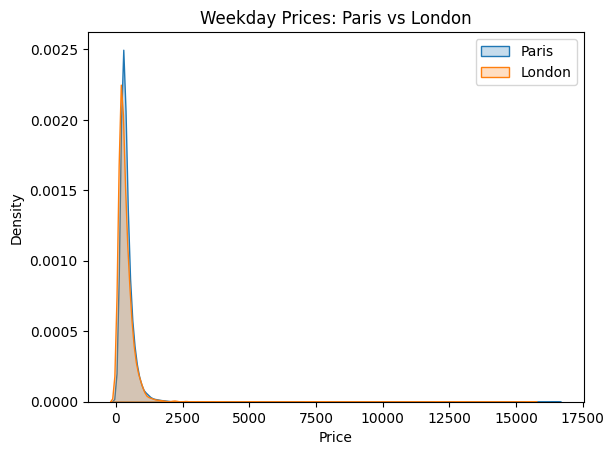

Paris vs London: t-test p-value = 0.00


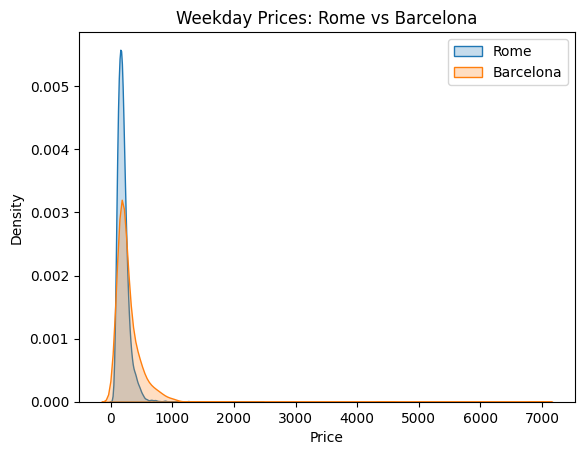

Rome vs Barcelona: t-test p-value = 0.00

Analysis: The t-test results indicate that there are statistically significant differences in weekday 
prices between all three pairs of cities (Amsterdam vs Berlin, Paris vs London, Rome vs Barcelona), 
with p-values effectively 0. This suggests that the average nightly price differs between these cities.



In [28]:
#Q.8 Is there a difference in price per night between two cities? Choose at least three pairs of cities during weekdays.
from scipy.stats import ttest_ind

# Filter weekday listings
weekday_df = merged_airbnbdf[merged_airbnbdf['day_type'] == 'Weekdays']

# City pairs
city_pairs = [('Amsterdam', 'Berlin'), ('Paris', 'London'), ('Rome', 'Barcelona')]

# Loop through each pair
for city1, city2 in city_pairs:
    prices1 = weekday_df[weekday_df['city'] == city1]['price']
    prices2 = weekday_df[weekday_df['city'] == city2]['price']
    
    # Plot KDE for the pair
    sns.kdeplot(prices1, label=city1, fill=True)
    sns.kdeplot(prices2, label=city2, fill=True)
    plt.title(f"Weekday Prices: {city1} vs {city2}")
    plt.xlabel("Price")
    plt.ylabel("Density")
    plt.legend()
    plt.show()
    
    # Perform Welch's t-test
    stat, p = ttest_ind(prices1, prices2, equal_var=False)
    print(f"{city1} vs {city2}: t-test p-value = {p:.2f}")

# Print Analysis
print("""
Analysis: The t-test results indicate that there are statistically significant differences in weekday 
prices between all three pairs of cities (Amsterdam vs Berlin, Paris vs London, Rome vs Barcelona), 
with p-values effectively 0. This suggests that the average nightly price differs between these cities.
""")

Average weekday price: 275.68
Average weekend price: 283.96
 
Analysis: As per analysis, the average price per night is certainly higher on weekends compared to
weekdays, indicating that Airbnb hosts probably charge a premium during weekends, likely due to higher demand. 
The boxplot shows that weekday prices have more variation and outliers, meaning there are more very low
and very high prices on weekdays. Weekend prices, while higher on average, are more consistently clustered.



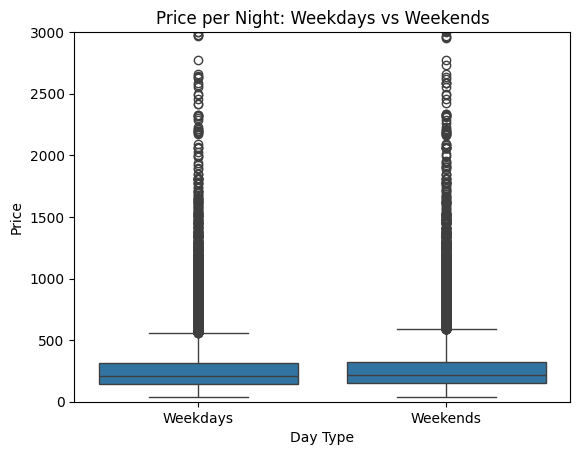

In [29]:
#Q.9 Does the price per night tend to be higher on weekends?

# Calculate mean prices
weekday_mean = merged_airbnbdf[merged_airbnbdf['day_type'] == 'Weekdays']['price'].mean()
weekend_mean = merged_airbnbdf[merged_airbnbdf['day_type'] == 'Weekends']['price'].mean()

print(f"Average weekday price: {weekday_mean:.2f}")
print(f"Average weekend price: {weekend_mean:.2f}")

# Boxplot to visualize distributions
sns.boxplot(x='day_type', y='price', data=merged_airbnbdf)
plt.title("Price per Night: Weekdays vs Weekends")
plt.ylabel("Price")
plt.xlabel("Day Type")
plt.ylim(0, 3000)


# Print Analysis
print(""" 
Analysis: As per analysis, the average price per night is certainly higher on weekends compared to
weekdays, indicating that Airbnb hosts probably charge a premium during weekends, likely due to higher demand. 
The boxplot shows that weekday prices have more variation and outliers, meaning there are more very low
and very high prices on weekdays. Weekend prices, while higher on average, are more consistently clustered.
""")


Average price for Superhost listings: 254.45 €
Average price for Normal host listings: 288.63 €

Analysis: The average superhosts listing price is 254.45 €, while normal host 
listings average 288.63 €. This indicates that, on average, Normal Host listings 
are slightly more expensive than Superhost listings. Superhosts do not charge systematically 
higher prices, though Normal Hosts exhibit more extreme high-price outliers.



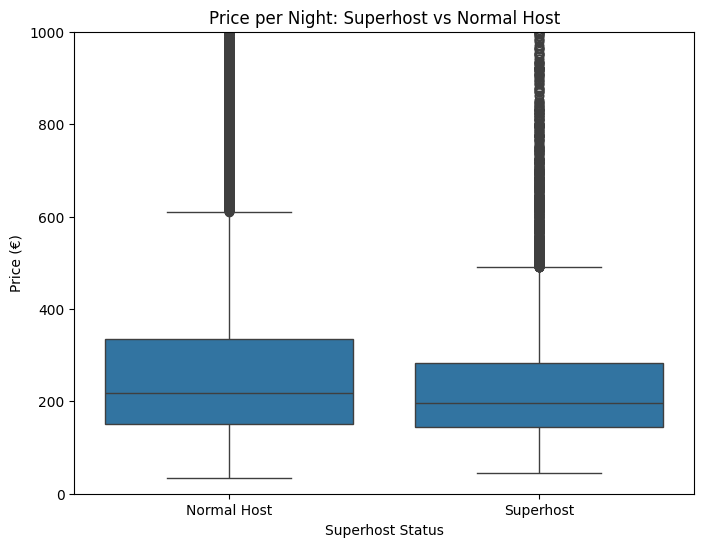

In [30]:
#Q.10 Are listings of superhosts more expensive than those of normal hosts? 

# Calculate mean prices by Superhost status
superhost_mean = merged_airbnbdf[merged_airbnbdf['host_is_superhost'] == True]['price'].mean()
normalhost_mean = merged_airbnbdf[merged_airbnbdf['host_is_superhost'] == False]['price'].mean()

print(f"Average price for Superhost listings: {superhost_mean:.2f} €")
print(f"Average price for Normal host listings: {normalhost_mean:.2f} €")

# Boxplot to visualize price distributions
plt.figure(figsize=(8,6))
sns.boxplot(x='host_is_superhost', y='price', data=merged_airbnbdf)

# Adjust axis labels and title
plt.title("Price per Night: Superhost vs Normal Host")
plt.ylabel("Price (€)")
plt.xlabel("Superhost Status")
plt.xticks([0,1], ['Normal Host', 'Superhost'])
plt.ylim(0, 1000)



# Analysis
print(f"""
Analysis: The average superhosts listing price is {superhost_mean:.2f} €, while normal host 
listings average {normalhost_mean:.2f} €. This indicates that, on average, Normal Host listings 
are slightly more expensive than Superhost listings. Superhosts do not charge systematically 
higher prices, though Normal Hosts exhibit more extreme high-price outliers.
""")



In [31]:
#Q.11 Are superhosts closer to the city center and metro station than normal hosts?

In [32]:
#Q.12 Are superhosts cleaner than normal hosts?

In [33]:
#Q.13 Is there a pattern between room types and superhost status?

In [34]:
#Q.14 Is renting an entire home/apt more expensive than a private room? Does that depend on the city?